# Modeling moth stories in MEG

Moth stories are played auditorily to subjects while they sit in the MEG scanner. So far we have one subject, one session. One story (wheretheressmoke) is repeated twice and serves as the test set. I believe it is best to average the data across the two repeats after it is downsampled.

Data is recorded originally as a rate of 1ms. We will use mne to downsample it. We resave the data structure after downsampling, to allow us to keep all the meta-data. 

In [1]:
# first load important packages
import os, glob
import mne
import numpy as np
import matplotlib.pyplot as plt
import h5py
from meg_sensor_plot import topoplot, single_topoplot
from sklearn.decomposition import PCA
# from wordfreq import word_frequency
from ridge_tools import cross_val_ridge, corr, R2, OLS
from scipy.stats import zscore
from utils import delay_mat

def delay_and_add_ones(mat, delays):
    mat = delay_mat(mat,delays)
    mat = np.concatenate([mat,np.ones((mat.shape[0],1))],axis=1)
    return mat

import warnings
warnings.filterwarnings('ignore')

/Users/lwehbe/env/py3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:30: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar', copy_X=True, eps=np.finfo(np.float).eps,
/Users/lwehbe/env/py3/lib/python3.7/site-packages/sklearn/linear_model/least_angle.py:167: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  method='lar'

## Loading and preparing data

### Loading raw data
The data is stored in a directory that indicates the preprocessing steps that have been made. The name indicates whether empty room data was used as a baseline, what filter was used, whether heart beats and blinks were removed, etc. 

The story order is specified during the experimental setup. It is important to keep a log file for every single session (time where a subject goes to the scanner) that indicates exactly which stories were played. 

We save here the name of the story in the downsampled file to avoid future confusion.

In [2]:
SUBJECT = 'A'
loc = "/Users/lwehbe/git_other/moth_meg/trans-D_nsb-5_cb-0_emptyroom-4-10-2-2_band-1-150_notch-60-120_beatremoval-first_blinkremoval-first/{}/".format(SUBJECT)
story_list = ['alternateithicatom',
	     'wheretheressmoke0',
	     'avatar',
	     'odetostepfather',
	     'wheretheressmoke1',
	     'souls']

story_list_unique = ['alternateithicatom',
	     'wheretheressmoke',
	     'avatar',
	     'odetostepfather',
	     'souls']

# used to go from names to unique names
unique_story_name = dict(alternateithicatom = 'alternateithicatom',
                      avatar = 'avatar',
                      odetostepfather = 'odetostepfather',
                      wheretheressmoke0 = 'wheretheressmoke',
                      wheretheressmoke1 = 'wheretheressmoke',
                      souls = 'souls')

# used to go from unique names to names
ununique_story_name = dict(alternateithicatom = 'alternateithicatom',
                      avatar = 'avatar',
                      odetostepfather = 'odetostepfather',
                      wheretheressmoke = 'wheretheressmoke0',
                      souls = 'souls')

train_story_list = ['alternateithicatom',
	     'avatar',
	     'odetostepfather',
	     'souls']
test_story_dict = dict(wheretheressmoke = ['wheretheressmoke0','wheretheressmoke1'])


#### TODO: 
Find out if the downsampled time window captures the preceeding or subsequent times. Check times. 

story: alternateithicatom, length: 708.02 seconds
story: wheretheressmoke0, length: 603.017 seconds
story: avatar, length: 756.021 seconds
story: odetostepfather, length: 830.023 seconds
story: wheretheressmoke1, length: 603.018 seconds
story: souls, length: 731.02 seconds


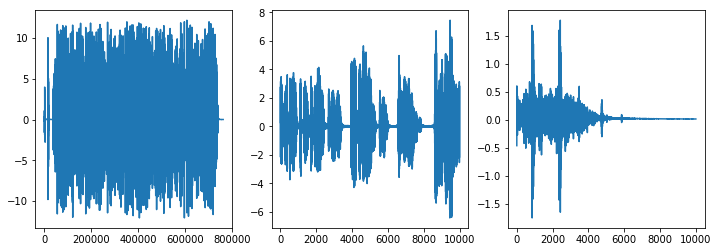

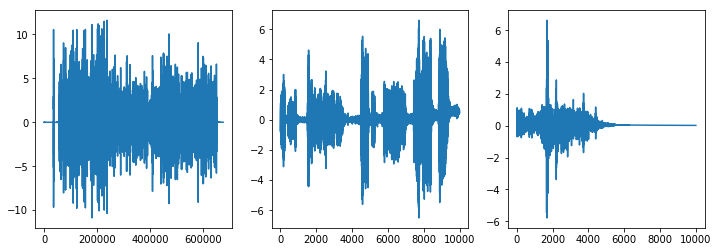

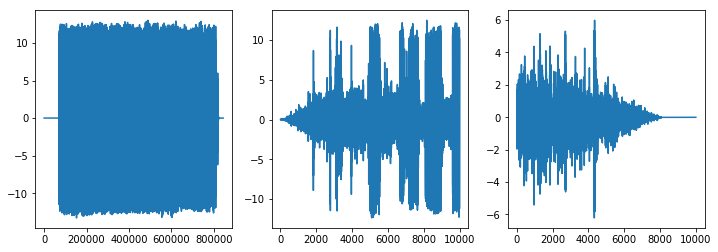

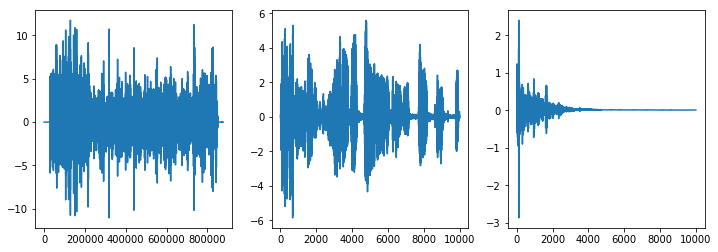

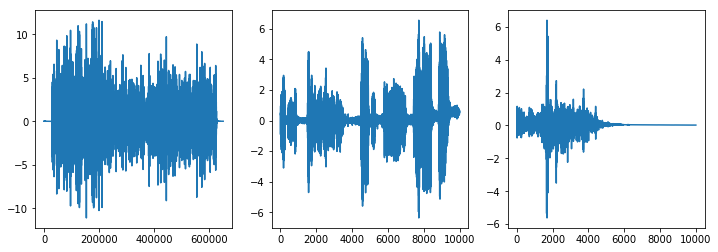

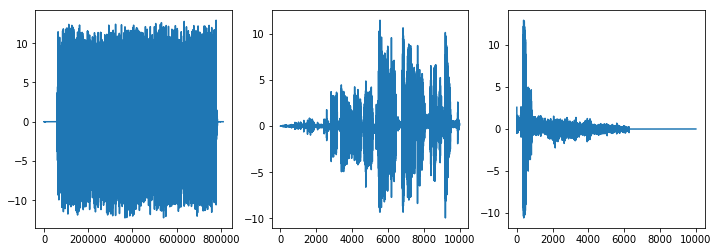

In [3]:
# you don't have to keep running this, it takes a long time to downsample! also you need access to the 
# full data for this step
do_sampling_and_save = 0
# use this to look at the alignment between the audio signal and when channel 312 is =5
do_inspect_audio_sig = 1

if do_sampling_and_save:
    # go in order
    files = sorted(glob.glob(loc+'{}_moth_aud*.fif'.format(SUBJECT)))
    print(len(files))
    fullstim_channel = dict()
    audio_channel = dict()
    count_story = 0
    for f in (files):
        if f.find('fif')!=-1 and not 'EmptyRoom' in f: # if a story run
            story = story_list[count_story]
            count_story+=1
            meg_story_data_full = mne.io.read_raw_fif(f)
            # save the original stimulus and audio channels 
            fullstim_channel[story] = meg_story_data_full.get_data()[312,:]
            audio_channel[story] = meg_story_data_full.get_data()[311,:]
            # downsample to a rate of 50Hz
            meg_story_data_full.resample(50)
            meg_story_data_full.save(loc+'Downsampled_{}.fif'.format(story))
    np.save(loc+'fullstim_channel.npy',fullstim_channel)
    np.save(loc+'audio_channel.npy',audio_channel)
    
fullstim_channel = np.load(loc+'fullstim_channel.npy',allow_pickle=True)[()]
audio_channel = np.load(loc+'audio_channel.npy',allow_pickle=True)[()]

    
if do_inspect_audio_sig:
    for i, story in enumerate(story_list):
        print('story: {}, length: {} seconds'.format(story, np.sum(fullstim_channel[story]==5)/1000))
        np.load(loc+'fullstim_channel.npy',allow_pickle=True)[()]
        np.load(loc+'audio_channel.npy',allow_pickle=True)[()]
        plt.figure(figsize=(12,4))
        plt.subplot(131)
        plt.plot(audio_channel[story])
        plt.subplot(132)
        plt.plot(audio_channel[story][fullstim_channel[story]==5][:10000])
        plt.subplot(133)
        plt.plot(audio_channel[story][fullstim_channel[story]==5][-10000:])
  

The plots above (when do_inspect_audio_sig=1) can be used to verify and debug when onset of stimulus is (there is a gap of a few seconds of data between the length of the audio and the time when stimulus channel is =5. Plotting this shows us these are at the end of the audio, so no need to account for them)
THIS NEEDS TO BE REVERIFIED LATER!!!

### Loading downsampled data

Now we can finally load the data

In [4]:
# now we load the saved, downsampled data

meg_story_data = dict()

for story in story_list:
    print(story)
    meg_story_data[story] = mne.io.read_raw_fif(loc+'Downsampled_{}.fif'.format(story))

alternateithicatom
Opening raw data file /Users/lwehbe/git_other/moth_meg/trans-D_nsb-5_cb-0_emptyroom-4-10-2-2_band-1-150_notch-60-120_beatremoval-first_blinkremoval-first/A/Downsampled_alternateithicatom.fif...
    Read a total of 24 projection items:
        planar-Raw-55.200-65.200-PCA-01 (1 x 204) active
        planar-Raw-55.200-65.200-PCA-02 (1 x 204) active
        axial-Raw-55.200-65.200-PCA-01 (1 x 102) active
        axial-Raw-55.200-65.200-PCA-02 (1 x 102) active
        planar-Raw-115.400-125.400-PCA-01 (1 x 204) active
        planar-Raw-115.400-125.400-PCA-02 (1 x 204) active
        axial-Raw-115.400-125.400-PCA-01 (1 x 102) active
        axial-Raw-115.400-125.400-PCA-02 (1 x 102) active
        planar-Raw-175.600-185.600-PCA-01 (1 x 204) active
        planar-Raw-175.600-185.600-PCA-02 (1 x 204) active
        axial-Raw-175.600-185.600-PCA-01 (1 x 102) active
        axial-Raw-175.600-185.600-PCA-02 (1 x 102) active
        planar-Raw-235.800-245.800-PCA-01 (1 x 204) 

        ECG-axial-999--0.200-0.400-PCA-02 (1 x 102) active
        EOG-planar-998--0.200-0.200-PCA-01 (1 x 204) active
        EOG-planar-998--0.200-0.200-PCA-02 (1 x 204) active
        EOG-axial-998--0.200-0.200-PCA-01 (1 x 102) active
        EOG-axial-998--0.200-0.200-PCA-02 (1 x 102) active
    Range : 4500 ... 36999 =     90.000 ...   739.980 secs
Ready.
souls
Opening raw data file /Users/lwehbe/git_other/moth_meg/trans-D_nsb-5_cb-0_emptyroom-4-10-2-2_band-1-150_notch-60-120_beatremoval-first_blinkremoval-first/A/Downsampled_souls.fif...
    Read a total of 24 projection items:
        planar-Raw-55.200-65.200-PCA-01 (1 x 204) active
        planar-Raw-55.200-65.200-PCA-02 (1 x 204) active
        axial-Raw-55.200-65.200-PCA-01 (1 x 102) active
        axial-Raw-55.200-65.200-PCA-02 (1 x 102) active
        planar-Raw-115.400-125.400-PCA-01 (1 x 204) active
        planar-Raw-115.400-125.400-PCA-02 (1 x 204) active
        axial-Raw-115.400-125.400-PCA-01 (1 x 102) active
       

### Select the relevant stimulus subset, zscore and concatenate

The first 306 channels are the MEG channels. The other channels have other information, including EOG, heart rate etc. Channel 312 contains the stimulus trigger used, and 5 corresponds to when the audio file was playing. Channel 311 has a low sampled version of the audio input (when played it doesn't sound right, missing info) but it can be used to double check things. Make do_inspect_audio_sig = 1 above and run that cell to inspect the audio signal...

For now, we will consider that the beginning of the 5 trigger is the beginning of the audio file.

In [5]:
print("last 20 MEG channels:", meg_story_data['alternateithicatom'].info.ch_names[-20:],'\n')

# Gets the data from the fif structure
data = dict([(s,d.get_data()) for s,d in meg_story_data.items()]) 
# Get the timing of each data point to be selected:
times = dict([(s,d.times[data[s][312,:]==5]) for s,d in meg_story_data.items()]) 

# this line transposes the data, selects the times when the trigger is 5, the first 306 channels, and zscores
data = dict([(s,zscore(d.T[d[312,:]==5,:306])) for s,d in data.items()]) 
# reset the times so they start at 0
times = dict([(s,d-d[0]) for s,d in times.items()]) 

print('resulting shapes of data: ',[(s,d.shape) for s,d in data.items()],'\n')
print('resulting timings: ',[(s,d[-1]) for s,d in times.items()],'\n')

last 20 MEG channels: ['MEG2611', 'MEG2623', 'MEG2622', 'MEG2621', 'MEG2633', 'MEG2632', 'MEG2631', 'MEG2642', 'MEG2643', 'MEG2641', 'EOG061', 'EOG062', 'ECG063', 'MISC006', 'MISC007', 'MISC008', 'STI101', 'STI102', 'STI201', 'STI301'] 

resulting shapes of data:  [('alternateithicatom', (35402, 306)), ('wheretheressmoke0', (30152, 306)), ('avatar', (37802, 306)), ('odetostepfather', (41502, 306)), ('wheretheressmoke1', (30152, 306)), ('souls', (36552, 306))] 

resulting timings:  [('alternateithicatom', 708.02), ('wheretheressmoke0', 603.02), ('avatar', 756.02), ('odetostepfather', 830.0200000000001), ('wheretheressmoke1', 603.02), ('souls', 731.02)] 



## Loading and creating features

### Phonemes

Phoneme and word information is provided as a datastructure called a grid file that indicates the beginning and end of each phoneme or word. 

In [6]:
import pickle
with open('/Users/lwehbe/git_other/moth_meg/moth_phon_words.pkl','rb') as fp:
    grid_transcript_phones = pickle.load(fp)
    grid_transcript_words = pickle.load(fp)

# # add the reps of the test data, not sure this is the best solution
# grid_transcript_phones['wheretheressmoke0'] = grid_transcript_phones['wheretheressmoke']
# grid_transcript_phones['wheretheressmoke1'] = grid_transcript_phones['wheretheressmoke']

# grid_transcript_words['wheretheressmoke0'] = grid_transcript_words['wheretheressmoke']
# grid_transcript_words['wheretheressmoke1'] = grid_transcript_words['wheretheressmoke']


Some phonemes appear very rarely, so it's good to only keep the ones that appear frequently enough. We construct design matrices for all stories that indicate when the phonemes are on, then we remove the rare phonemes

In [7]:
# get all unique phonemes across all stories
all_phones = np.unique(np.concatenate([np.unique([s[2] for s in g]) for g in grid_transcript_phones.values()],0))
n_all_phones = len(all_phones)
print('there is {} unique phonemes: '.format(n_all_phones),all_phones)

there is 102 unique phonemes:  ['' ' DH' 'AA0' 'AA1' 'AA2' 'AE0' 'AE1' 'AE2' 'AH' 'AH0' 'AH0V' 'AH1'
 'AH2' 'AHN' 'AO' 'AO0' 'AO1' 'AO2' 'AW1' 'AW2' 'AY' 'AY0' 'AY1' 'AY2' 'B'
 'BR' 'C' 'CH' 'D' 'DH' 'EH' 'EH0' 'EH1' 'EH2' 'ER' 'ER0' 'ER1' 'ER2'
 'EY0' 'EY1' 'EY2' 'F' 'G' 'H' 'HH' 'IH0' 'IH1' 'IH2' 'IHS' 'IY' 'IY0'
 'IY1' 'IY2' 'JH' 'K' 'L' 'LG' 'M' 'N' 'NG' 'NS' 'OA1' 'OW' 'OW0' 'OW1'
 'OW2' 'OY1' 'OY2' 'P' 'R' 'S' 'SH' 'ST' 'T' 'TH' 'UH1' 'UH2' 'UW0' 'UW1'
 'UW2' 'V' 'W' 'Y' 'Z' 'ZH' 'ah1' 'br' 'br ' 'brls' 'cg' 'lg' 'ls' 'ns'
 's' 'sil' 'sp' 'spAH1' 'spM' 'sp\x7f' '{CG}' '{IG}' '{NS}']


54 phonemes are left:  ['' 'AA1' 'AA2' 'AE1' 'AE2' 'AH0' 'AH1' 'AO1' 'AW1' 'AY1' 'AY2' 'B' 'CH'
 'D' 'DH' 'EH1' 'ER0' 'ER1' 'EY1' 'EY2' 'F' 'G' 'HH' 'IH0' 'IH1' 'IH2'
 'IY0' 'IY1' 'JH' 'K' 'L' 'M' 'N' 'NG' 'OW1' 'OY1' 'P' 'R' 'S' 'SH' 'T'
 'TH' 'UH1' 'UW1' 'V' 'W' 'Y' 'Z' 'br' 'cg' 'lg' 'ls' 'ns' 'sp']


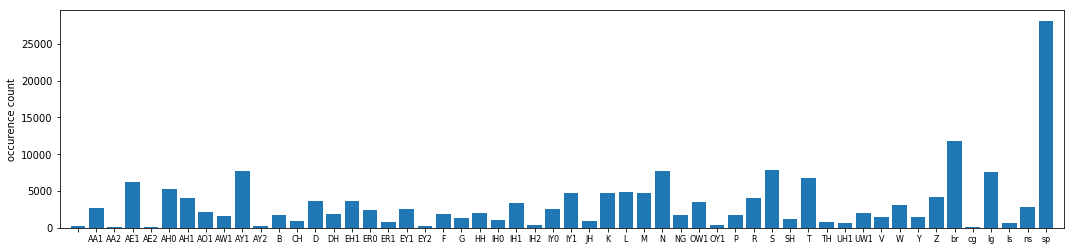

In [8]:
phonemes_design_mat = dict()

for story in story_list_unique:
    # get number of time points in story
    time_vec = times[ununique_story_name[story]]
    n_times = len(time_vec)
    design_mat = np.zeros((n_times,n_all_phones))

    for g in grid_transcript_phones[story]: # for each phoneme
        # get the time points in intersects with
        ind_times = np.where((time_vec>float(g[0]))*(time_vec<=float(g[1])))[0]
        ind_g = np.where(all_phones==g[2])[0]
        design_mat[ind_times,ind_g] =1
        
    phonemes_design_mat[story] = design_mat

# now get rid of rare phonemes, sum over all the design matrices and keep the phonemes that appear >100 times
all_phoneme_count = np.concatenate(list(phonemes_design_mat.values()),axis=0).sum(0)
keep_phones = np.where(all_phoneme_count>100)[0]

phonemes_design_mat = dict([(s,p[:,keep_phones]) for s,p in phonemes_design_mat.items()])
phonemes = all_phones[keep_phones]
print('{} phonemes are left: '.format(len(phonemes)),phonemes)

plt.figure(figsize = (18,4))
plt.bar(np.arange(len(phonemes)),all_phoneme_count[keep_phones])
plt.xticks(np.arange(len(phonemes)), phonemes,fontsize=8);
plt.xlim([-1,len(phonemes)]);
plt.ylabel('occurence count');

### Spectral features

These stories only contain speech, no enviromental sounds. However, it can still be that the power spectrum of the sound is a better predictor of the neural activity than the phonemes. Phonemes might be a conceptual categorization that is not as relevant for brains as we think.

Here we construct the [spectrogram](https://en.wikipedia.org/wiki/Spectrogram) of the audiofile and then downsample in both time and frequency to keep things computationally efficient. 

We need the original audio file here! 

alternateithicatom
original audio_signal length 31165029, frequency 44100, total time 706.69
meg data length: 708.02
added 68 zeros rows to spectral2, corresponding to 1.3600000000002126 sec

wheretheressmoke0
original audio_signal length 26545481, frequency 44100, total time 601.9383446712018
meg data length: 603.02
added 56 zeros rows to spectral2, corresponding to 1.120000000000175 sec

avatar
original audio_signal length 33262793, frequency 44100, total time 754.2583446712018
meg data length: 756.02
added 90 zeros rows to spectral2, corresponding to 1.7999999999996419 sec

odetostepfather
original audio_signal length 36519504, frequency 44100, total time 828.1066666666667
meg data length: 830.0200000000001
added 97 zeros rows to spectral2, corresponding to 1.9399999999999586 sec

wheretheressmoke1
original audio_signal length 26545481, frequency 44100, total time 601.9383446712018
meg data length: 603.02
added 56 zeros rows to spectral2, corresponding to 1.1199999999999761 sec

sou

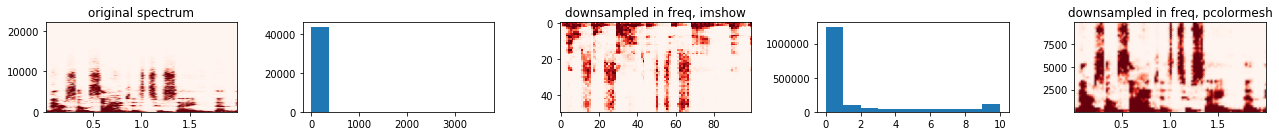

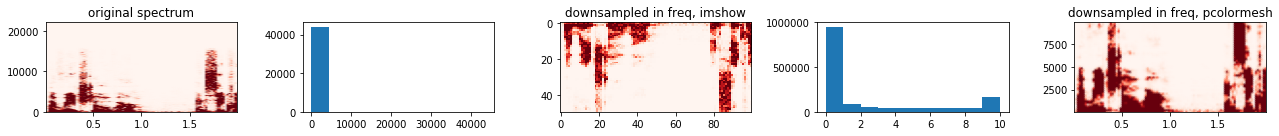

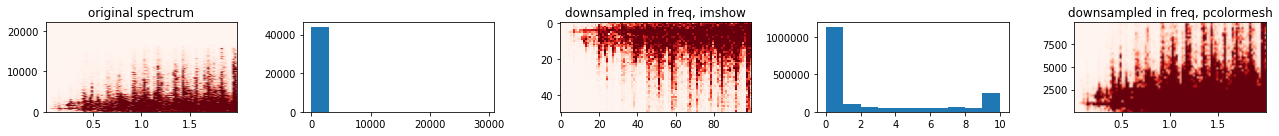

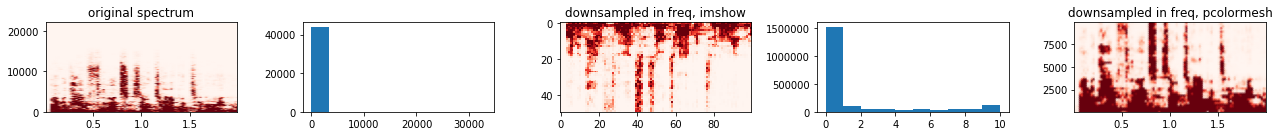

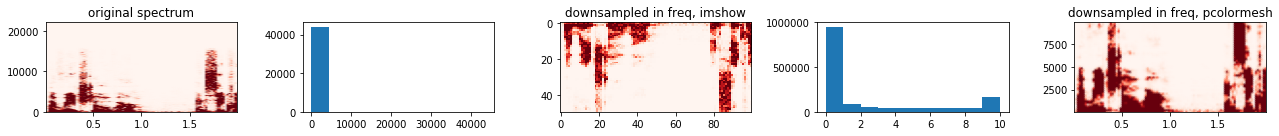

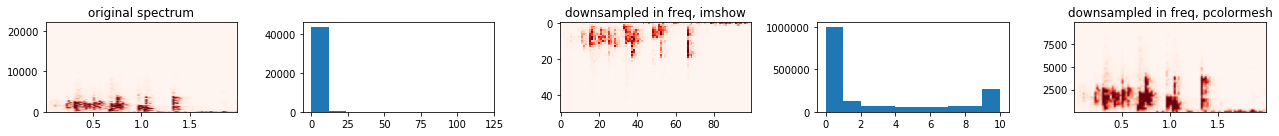

In [9]:
from scipy.io import wavfile
from scipy.signal import spectrogram
from matplotlib.pyplot import pcolormesh


# loading the audio files and running this allows us
# to check that all the timings match
do_compute_spectrogram = 1

spectrum = dict()
## TODO: CHECK THAT THE FREQUENCY BINS HERE MAKE SENSE!
spectrum_frequency_bins = dict()
spectrum_time_bins = dict()



if do_compute_spectrogram:
    audio = dict()
    audio_file = dict(alternateithicatom = 'alternateithicatom.wav',
                      avatar = 'avatar-norm.wav',
                      odetostepfather = 'odetostepfather.wav',
                      # using there instead of the unique file names to verify that every 
                      # MEG file is correct. when writing the results, the 
                      # unique name is used
                      wheretheressmoke0 = 'wheretheressmoke-norm-1.wav',
                      wheretheressmoke1 = 'wheretheressmoke-norm-1.wav',
                      souls = 'souls.wav')
    for story in story_list:
        audio= wavfile.read(loc+audio_file[story])
        audio_sampling_frequency = audio[0]
        audio_signal = audio[1][:,0]
        print(story)
        print('original audio_signal length {}, frequency {}, total time {}'.format(len(audio_signal),
                                                                             audio_sampling_frequency,
                                                                             len(audio_signal)/audio_sampling_frequency))
        print('meg data length: {}'.format(times[story][-1]) )
        
        # choose a window size that fits the MEG sampling rate
        freq_interval, time_interval, spectr  = spectrogram(audio_signal, fs=audio_sampling_frequency,
                                                   nfft = 882,nperseg=882,noverlap=0)
        # CAREFUL NOT TO PLOT THE ENTIRE spectr THIS WILL RESULT IN A MEMORY ERROR
        fig, ax = plt.subplots(1,5,figsize=(18,2))
        ax[0].pcolormesh(time_interval[:100], freq_interval, spectr[:,:100], 
                         shading='gouraud',vmin=0,vmax=4,cmap='Reds');
        ax[0].set_title('original spectrum')
        ax[1].hist(spectr[:,:100].ravel()) ## huge outliers
        # not much is going on above 10KHz, hence, clip after the first 200 frequency bins 
        spectral = spectr.T[:,:200]
        # plotting using imshow made me notice crazy outliers, hence, I clipped the spectrum at 10
        spectral[spectral>10] = 10
        # still too many frequency bins, downsample in frequency
        spectral2 = np.vstack([s.mean(1) for s in np.split(spectral,50,axis = 1)]).T
        freq_interval_2 = np.array([s.mean() for s in np.split(freq_interval[:200],50,axis = 0)]).T
        ax[2].imshow(spectral2[:100].T,cmap='Reds',aspect ='auto')
        ax[2].set_title('downsampled in freq, imshow')
        # show new distribution
        ax[3].hist(spectral2[:,:100].ravel())
        # CAREFUL NOT TO PLOT THE ENTIRE spectral2 THIS WILL RESULT IN A MEMORY ERROR
        ax[4].pcolormesh(time_interval[:100], freq_interval_2, spectral2[:100,:].T, 
                         shading='gouraud',vmin=0,vmax=4,cmap='Reds');
        ax[4].set_title('downsampled in freq, pcolormesh')
        fig.tight_layout()
        
        # TODO: MAKE THIS THIS IS CORRECT TO ADD AT THE END: extend time bins:
        len_time = len(times[story])
        diff_len = len_time - spectral2.shape[0] 
        print('added {} zeros rows to spectral2, corresponding to {} sec\n'.format(diff_len,
                                                                          diff_len*(times[story][1]-times[story][0])))
        spectral2 = np.concatenate([spectral2,np.zeros((diff_len,spectral2.shape[1]))],axis=0)
        time_interval= np.concatenate([time_interval,np.zeros((diff_len))],axis=0)
        spectrum[unique_story_name[story]] = spectral2
        spectrum_frequency_bins[unique_story_name[story]] = freq_interval_2
        spectrum_time_bins[unique_story_name[story]] = time_interval
    np.save(loc+'spectrum.npy',spectrum)
    np.save(loc+'spectrum_frequency_bins.npy',spectrum_frequency_bins)
    np.save(loc+'spectrum_time_bins.npy',spectrum_time_bins)


In [10]:
# load frequency info
spectrum = np.load(loc+'spectrum.npy',allow_pickle=True)[()]
spectrum_frequency_bins = np.load(loc+'spectrum_frequency_bins.npy',allow_pickle=True)[()]
spectrum_time_bins = np.load(loc+'spectrum_time_bins.npy',allow_pickle=True)[()]


### Semantic features

In [11]:
do_recompute_embeddings = 0



if do_recompute_embeddings:
    do_pca = 1

    ind_elmo_layers = dict(emb = 0, L1 = 1, L2 = 2, R1 = 3, R2 = 4)
    filename = loc + 'moth_e2.hdf'
    tmp = h5py.File(filename,'r')
    elmo_features = dict( [(s, np.array(tmp.get(s))) for s in story_list_unique])
    print('elmo_feature_shapes = ',[(s,v.shape) for s,v in elmo_features.items()])

    emb_mat = dict([(s,v[ind_elmo_layers['emb']]) for s,v in elmo_features.items()])
    first_layer_forward = dict([(s,v[ind_elmo_layers['L1']]) for s,v in elmo_features.items()])
    first_layer_forward = dict([(s,delay_mat(v,[1])) for s,v in first_layer_forward.items()])
    
    # could change this to make it such that the pcs are learned over the training data and applied to 
    # train and test
    if do_pca:
        tmp_m = np.vstack([v for v in emb_mat.values()])
        m_tmp_m = tmp_m.mean(0)
        tmp_m = tmp_m - m_tmp_m
        pca = PCA(n_components = 15).fit(tmp_m)
        for k,d in emb_mat.items():
            # the mean was removed when the data is concatenated, replicating this here
            mat = d - m_tmp_m
            emb_mat[k] = pca.transform(mat)
        tmp_m = np.vstack([v for v in first_layer_forward.values()])
        m_tmp_m = tmp_m.mean(0)
        tmp_m = tmp_m - m_tmp_m
        pca2 = PCA(n_components = 15).fit(tmp_m)
        for k,d in first_layer_forward.items():
            # the mean was removed when the data is concatenated, replicating this here
            mat = d - m_tmp_m
            first_layer_forward[k] = pca2.transform(mat)

    # compute supraword meaning # TODO should this be over training data?
    embeddings = np.vstack([emb_mat[s] for s in story_list_unique])
    embeddings_previous = delay_and_add_ones(embeddings, np.arange(0,20))
    first_layer_stacked = np.vstack([first_layer_forward[s] for s in story_list_unique]) 
#     first_layer_stacked = delay_mat(first_layer_stacked,[1])
#     weights,__ = cross_val_ridge(embeddings_previous,first_layer_stacked,n_splits = 10)
    weights = OLS(embeddings_previous,first_layer_stacked)

    supraword = dict([(s,v - delay_and_add_ones(emb_mat[s],np.arange(0,20)).dot(weights) )
                      for s,v in first_layer_forward.items()])

    np.save(loc+'supraword.npy',supraword)
    np.save(loc+'emb_mat.npy',emb_mat)
    np.save(loc+'first_layer_forward.npy',first_layer_forward)
else:
    supraword = np.load(loc+'supraword.npy',allow_pickle=True)[()]
    emb_mat = np.load(loc+'emb_mat.npy',allow_pickle=True)[()]
    first_layer_forward = np.load(loc+'first_layer_forward.npy',allow_pickle=True)[()]

elmo_feature_shapes =  [('alternateithicatom', (5, 2681, 512)), ('wheretheressmoke', (5, 2308, 512)), ('avatar', (5, 1952, 512)), ('odetostepfather', (5, 3300, 512)), ('souls', (5, 2481, 512))]


#### Creating a semantic design matrix

The issue here is that the word appears at a rate much slower than the MEG signal, and the same word can appear with different lengths, which interferes with processing. For example, when you hear the word refrigerator spoken  slowly, you probably understand the word before the speaking is finished! How do we reconciliate this with the need to map the semantic meaning to time?

This is going to be one of our research questions. For now, we will label all time points that intersect with a word with that word. If one time bins overlap with two words, we average them (this is also to revisit).

We will proceed with a similar fashion to the phonemes.

In [12]:
emb_design_mat = dict()
L1_design_mat = dict()
supraword_design_mat = dict()
p_emb = supraword[story_list[0]].shape[1]

for story in story_list_unique:
    time_vec = times[ununique_story_name[story]]
    # get number of time points in story
    n_times = len(time_vec)
    
    design_mat_s = np.zeros((n_times,p_emb))
    design_mat_e = np.zeros((n_times,p_emb))
    design_mat_L = np.zeros((n_times,p_emb))
    count_words_in_bin = np.zeros((n_times,1))

    for ig,g in enumerate(grid_transcript_words[story]): # for each word
        # get the time points in intersects with
        ind_times = np.where((time_vec>float(g[0]))*(time_vec<=float(g[1])))[0]
        design_mat_s[ind_times,:] += supraword[story][ig,:]
        design_mat_e[ind_times,:] += emb_mat[story][ig,:]
        design_mat_L[ind_times,:] += first_layer_forward[story][ig,:]
        count_words_in_bin[ind_times,:] += 1
    # to avoid nans:
    count_words_in_bin[count_words_in_bin==0]=1
    design_mat_s /= count_words_in_bin
    design_mat_e /= count_words_in_bin
    design_mat_L /= count_words_in_bin
     
    supraword_design_mat[story] = design_mat_s
    emb_design_mat[story] = design_mat_e
    L1_design_mat[story] = design_mat_L
    

Now we have time aligned information:

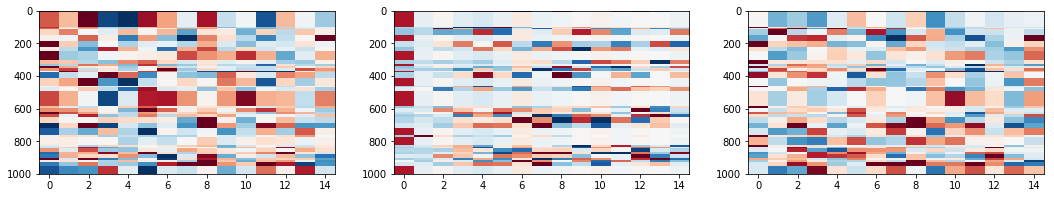

In [13]:
## use a dictionary to save plotting settings
plot_settings = dict(aspect = 'auto',vmin=-2,vmax=2,cmap='RdBu_r')

fig, ax = plt.subplots(1,3,figsize=(18,3))
ax[0].imshow(zscore(supraword_design_mat['avatar'])[1000:2000,:], **plot_settings)
ax[1].imshow(zscore(emb_design_mat['avatar'])[1000:2000,:], **plot_settings)
ax[2].imshow(zscore(L1_design_mat['avatar'])[1000:2000,:], **plot_settings)

## Run spatiotemporal encoding models

You can see here how we can use delays to eaily run a spatial encoding model analysis. Inspecting the weights properly also allows us to check at what delay does each feature contribute most to the signal.

If we constrict the delays into groups we can also look at the prediction performance in a spatio-temporal ways. See examples below, using each feature.

First prepare the MEG data, and the modeling function:

In [14]:
# concatenate training data, recall, this data is already zscored:
Y_train = np.concatenate([data[s] for s in train_story_list],axis=0)
print('Y_train shape ',Y_train.shape )

# average the test data. Let's pretend we have many test stories that 
# are each repeated, so we can reuse the code later

ave_test_data = dict()
for s,v in test_story_dict.items():
    ave_test_data[s] = np.mean( np.stack( [data[story] for story in v] ), axis=0)


Y_test = np.concatenate([ave_test_data[s] for s in test_story_dict.keys()],axis=0)
print('Y_test shape ',Y_test.shape )


Y_train shape  (151258, 306)
Y_test shape  (30152, 306)


In [15]:
# use this simple function

## add intercept term in case things are not zscored
def fit_model_predict_test(X_train,Y_train,X_test,Y_test,delays):
    # delay matrices
    X_train_del = delay_and_add_ones(X_train,delays)
    X_test_del = delay_and_add_ones(X_test,delays)
    # compute weights
    weights, lambdas = cross_val_ridge(X_train_del, Y_train,n_splits=4)
    # estimate on held-out data
    corrs = corr(Y_test,X_test_del.dot(weights) )
    return corrs, weights, lambdas

### Phoneme analysis, spatial

What is the best time windows to include? Remember each delay step is 20ms. We should look more into the litterature. 0-300ms can be a rule of thumb? 

Also, delays can be negative, what does that mean?

In [16]:
do_run = 1

delta_time = int((times[story_list[0]][1]-times[story_list[0]][0])*1000) # time in ms


if do_run:
    # specify X_train, X_test and the delays
    X_train = np.concatenate([phonemes_design_mat[s] for s in train_story_list],axis=0)
    X_test = np.concatenate([phonemes_design_mat[s] for s in test_story_dict.keys()],axis=0)

    delays = np.arange(0,10)
    # specify the timings to understand what it corresponds to:
    print('the time step is {} ms'.format(delta_time))
    print('chosen delays are {} to {} ms'.format(delta_time*delays[0], delta_time*delays[-1]))

    corrs_phonemes,weights,lambdas = fit_model_predict_test(X_train,Y_train,X_test,Y_test,delays)
    
    # save results
    np.save(loc+'corrs_phonemes.npy',corrs_phonemes)
    np.save(loc+'weights_phonemes.npy',weights)
    np.save(loc+'delays_phonemes.npy',delays)
    
else:
    #load results
    corrs_phonemes = np.load(loc+'corrs_phonemes.npy',allow_pickle='True')[()]
    weights = np.load(loc+'weights_phonemes.npy',allow_pickle='True')[()]
    delays = np.load(loc+'delays_phonemes.npy',allow_pickle='True')[()]
    


the time step is 20 ms
chosen delays are 0 to 180 ms
ntrain = 113443
iteration time 12.944980144500732


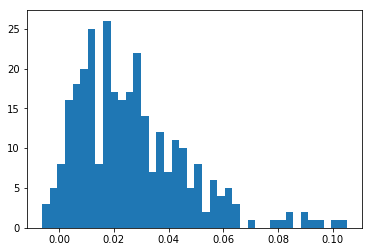

In [17]:
# histogram of the correlations across sensors
plt.hist(corrs_phonemes,40);

Spatial prediction using phonemes and delays 0 to 180


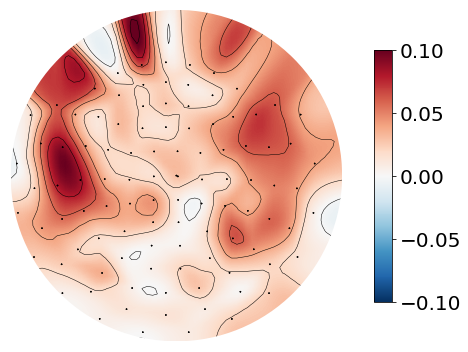

In [18]:
## TODO check what the topoplot does with multiple channels in the same location 
vmin = -0.1
vmax = 0.1
single_topoplot(corrs_phonemes,vmin=vmin,vmax=vmax);
print('Spatial prediction using phonemes and delays {} to {}'.format(delta_time*delays[0], delta_time*delays[-1]))

We can inspect the weights that were learned for let's say the top channel, by reshaping them according to the delays. This allows us to see what is being used to predict, and when. This is like a delay receptive field. See [this tutorial](https://mne.tools/dev/generated/mne.decoding.ReceptiveField.html). We are basically doing the same thing, perhaps even with less steps.

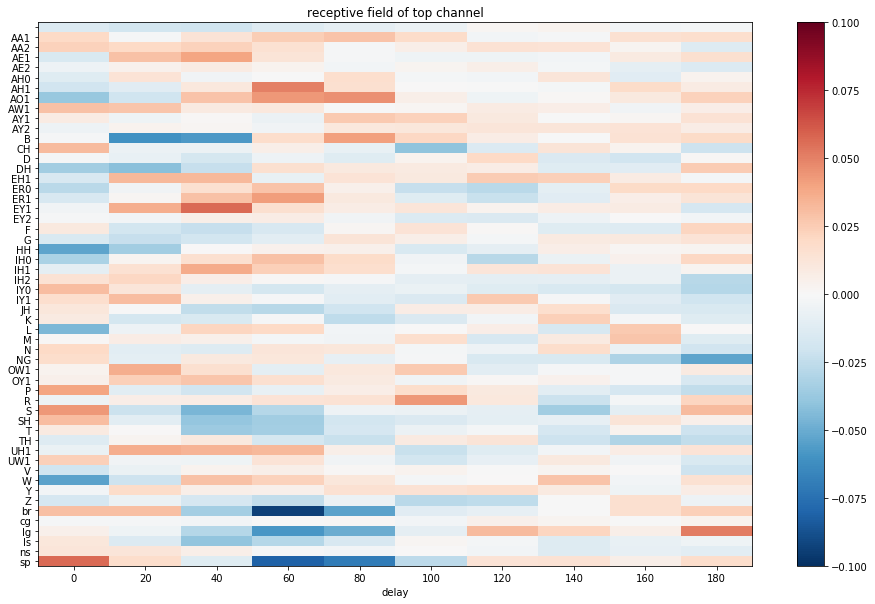

In [19]:
plt.figure(figsize=(16,10))

# show sum of weights over channels?
# plt.imshow(np.vstack(np.split(np.sum(weights, 1),len(delays))).T,
#            cmap='RdBu_r',vmin=-1,vmax=1,aspect='auto');

# show weights of top channel?
plt.imshow(np.vstack(np.split(weights[:-1,np.argmax(corrs_phonemes)],len(delays))).T,
           cmap='RdBu_r',vmin=-0.1,vmax=0.1,aspect='auto');


plt.yticks(np.arange(len(phonemes)),phonemes);
plt.xticks(np.arange(len(delays)),delays*delta_time);
plt.title('receptive field of top channel');
plt.xlabel('delay')
plt.colorbar();

What does the graph above mean? Look at the below graph, which is the average of the weights for that channel for the 'A*' phonemes:

Text(0.5, 0, 'delay')

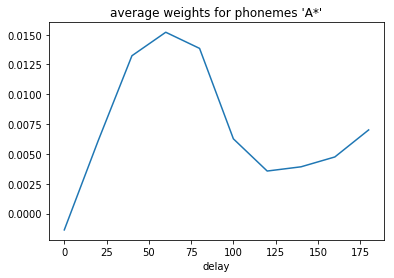

In [20]:
tmp = np.vstack(np.split(weights[:-1,np.argmax(corrs_phonemes)],len(delays))).T
plt.plot(delays*delta_time, tmp[1:11].mean(0));
plt.title('average weights for phonemes \'A*\'');
plt.xlabel('delay')

### Phoneme analysis, spatiotemporal

We can repeat the following by looking at different time bins. Using one time bin at a time might take a long time, and also might result in less accurate prediction. This is another research question, what time steps to take?

For now, let's use the following sets of delays:

In [21]:
do_run = 1

if do_run:
    
    X_train = np.concatenate([phonemes_design_mat[s] for s in train_story_list],axis=0)
    X_test = np.concatenate([phonemes_design_mat[s] for s in test_story_dict.keys()],axis=0)
    
    # go in steps of 100 ms
    # delay_sets = [np.arange(i,i+5) for i in range(-5,20,5)]

    # go in steps of 20 ms
    delay_sets = [np.arange(i,i+1) for i in range(0,6)]
    corrs_spatiotemporal_phonemes = np.zeros((306, len(delay_sets)))

    for i,delays in enumerate(delay_sets):
        print('using delays ', delays)
        corrs_spatiotemporal_phonemes[:,i],__,__ = fit_model_predict_test(X_train,Y_train,
                                                X_test,Y_test,delays)
    np.save(loc+'corrs_spatiotemporal_phonemes.npy',corrs_spatiotemporal_phonemes)
    np.save(loc+'delay_sets_phonemes.npy',delay_sets)
    
else:
    corrs_spatiotemporal_phonemes = np.load(loc+'corrs_spatiotemporal_phonemes.npy',allow_pickle='True')[()]
    delay_sets = np.load(loc+'delay_sets_phonemes.npy',allow_pickle='True')[()]
    


using delays  [0]
ntrain = 113443
iteration time 3.615767002105713
using delays  [1]
ntrain = 113443
iteration time 3.532411813735962
using delays  [2]
ntrain = 113443
iteration time 3.770587921142578
using delays  [3]
ntrain = 113443
iteration time 3.5572280883789062
using delays  [4]
ntrain = 113443
iteration time 3.9796741008758545
using delays  [5]
ntrain = 113443
iteration time 3.5002918243408203


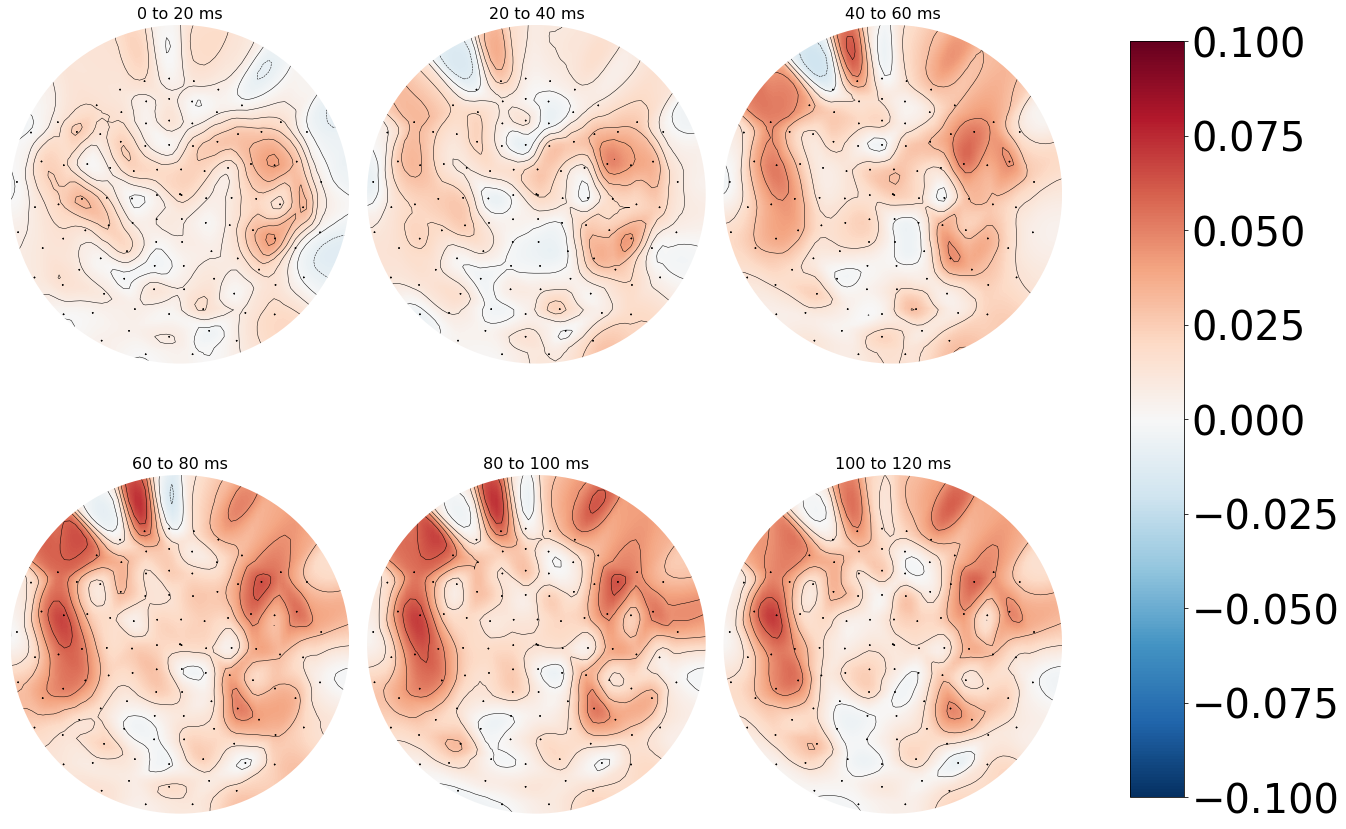

In [22]:
vmin = -0.1
vmax = 0.1
time_step = delta_time*len(delay_sets[0])

topoplot(corrs_spatiotemporal_phonemes,nrow=2,ncol=3,time_step=time_step,
                     time_start=delay_sets[0][0]*time_step,vmin=vmin,vmax=vmax);

### Spectral analysis, spatial


the time step is 20 ms
chosen delays are 0 to 180 ms
ntrain = 113443
iteration time 13.428143978118896
Spatial prediction using spectrogram and delays 0 to 180


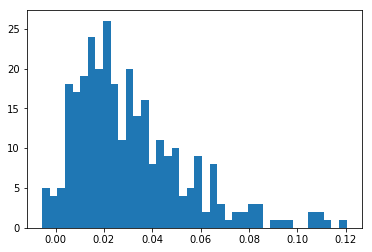

<Figure size 432x288 with 0 Axes>

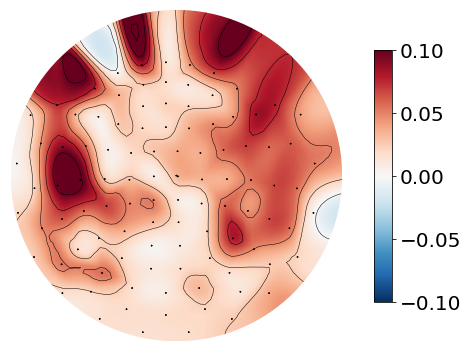

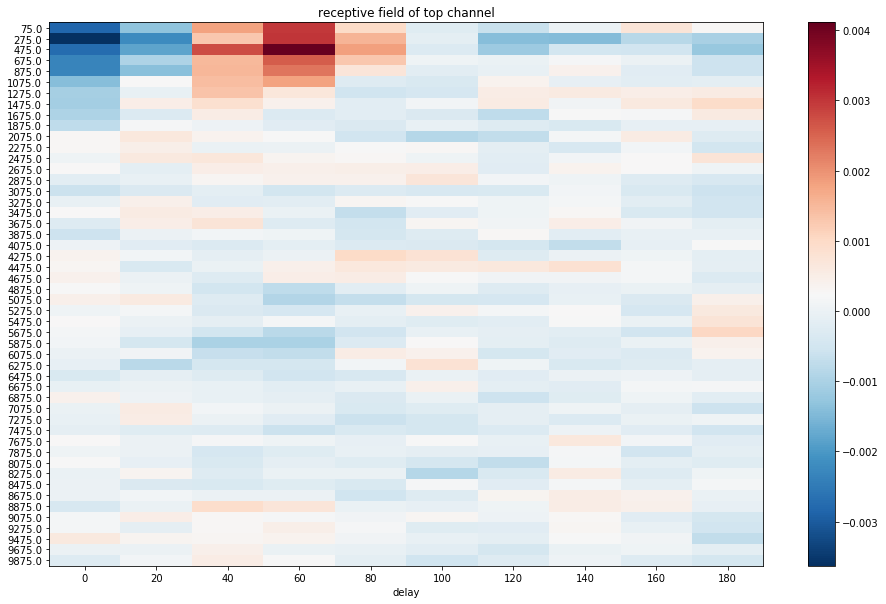

In [23]:
do_run = 1

if do_run:
    # specify X_train, X_test and the delays
    X_train = np.concatenate([spectrum[s] for s in train_story_list],axis=0)
    X_test = np.concatenate([spectrum[s] for s in test_story_dict.keys()],axis=0)

    delays = np.arange(0,10)
    # specify the timings to understand what it corresponds to:
    print('the time step is {} ms'.format(delta_time))
    print('chosen delays are {} to {} ms'.format(delta_time*delays[0], delta_time*delays[-1]))

    corrs_spec,weights,lambdas = fit_model_predict_test(X_train,Y_train,X_test,Y_test,delays)
    np.save(loc+'corrs_spec.npy',corrs_spec)
    np.save(loc+'weights_spec.npy',weights)
    np.save(loc+'delays_spec.npy',delays)
else:
    corrs_spec = np.load(loc+'corrs_spec.npy',allow_pickle='True')[()]
    weights = np.load(loc+'weights_spec.npy',allow_pickle='True')[()]
    delays = np.load(loc+'delays_spec.npy',allow_pickle='True')[()]

# histogram of the correlations across sensors
plt.figure()
plt.hist(corrs_spec,40);

vmin = -0.1
vmax = 0.1
plt.figure()
single_topoplot(corrs_spec,vmin=vmin,vmax=vmax);
print('Spatial prediction using spectrogram and delays {} to {}'.format(delta_time*delays[0], delta_time*delays[-1]))

plt.figure(figsize=(16,10))
# show weights of top channel?
plt.imshow(np.vstack(np.split(weights[:-1,np.argmax(corrs_spec)],len(delays))).T, # remove intercept term
           cmap='RdBu_r',aspect='auto');

spec_bins = spectrum_frequency_bins[story_list[0]]
plt.yticks(np.arange(len(spec_bins)),spec_bins);
plt.xticks(np.arange(len(delays)),delays*delta_time);
plt.title('receptive field of top channel');
plt.xlabel('delay')
plt.colorbar();

### Spectral analysis, spatiotemporal


using delays  [0]
ntrain = 113443
iteration time 3.466265916824341
using delays  [1]
ntrain = 113443
iteration time 3.6644201278686523
using delays  [2]
ntrain = 113443
iteration time 3.6639838218688965
using delays  [3]
ntrain = 113443
iteration time 3.762977123260498
using delays  [4]
ntrain = 113443
iteration time 3.633992910385132
using delays  [5]
ntrain = 113443
iteration time 3.861273765563965


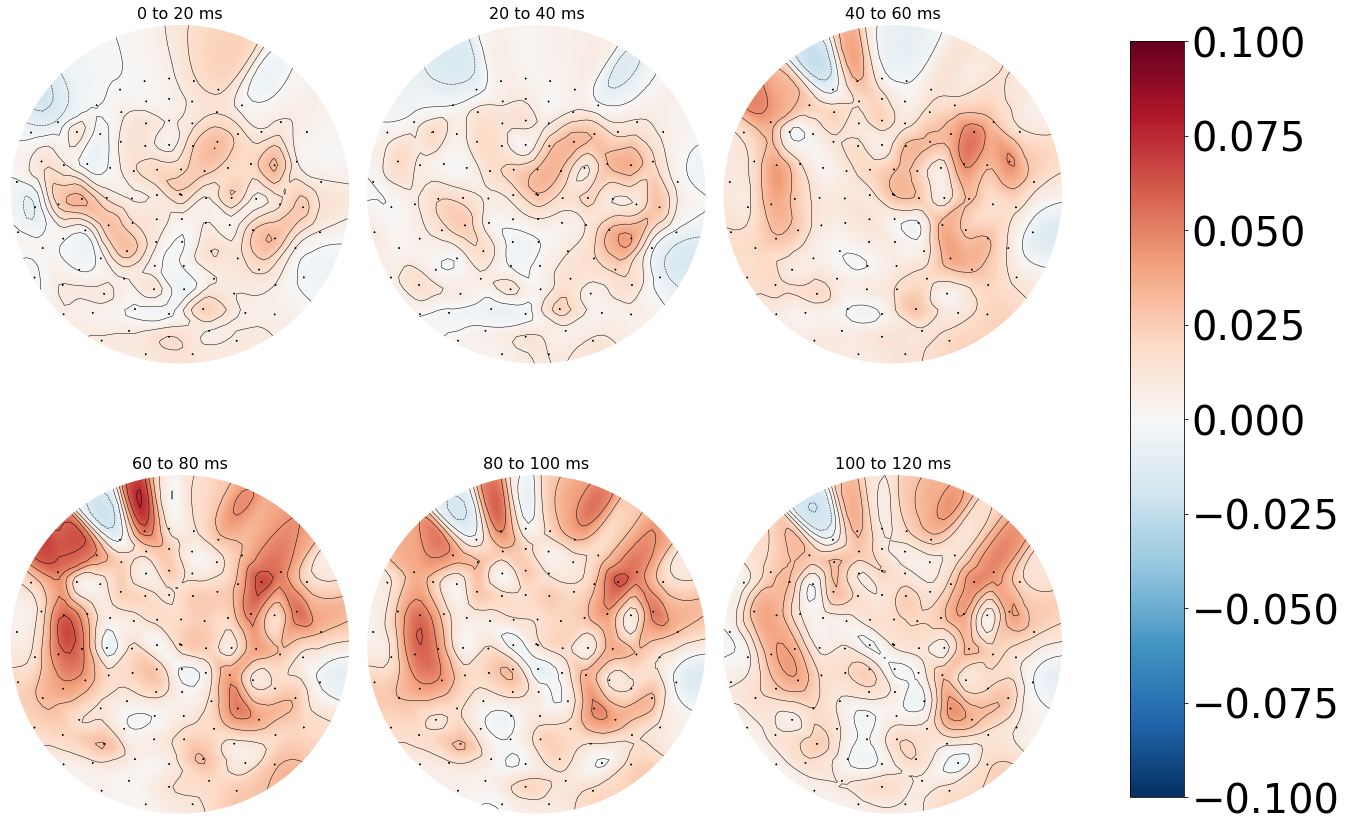

In [24]:
do_run = 1

if do_run:
    
    X_train = np.concatenate([spectrum[s] for s in train_story_list],axis=0)
    X_test = np.concatenate([spectrum[s] for s in test_story_dict.keys()],axis=0)
   

    # go in steps of 100 ms
    # delay_sets = [np.arange(i,i+5) for i in range(-5,20,5)]

    # go in steps of 20 ms
    delay_sets = [np.arange(i,i+1) for i in range(0,6)]
    corrs_spatiotemporal_spec = np.zeros((306, len(delay_sets)))

    for i,delays in enumerate(delay_sets):
        print('using delays ', delays)
        corrs_spatiotemporal_spec[:,i],__,__ = fit_model_predict_test(X_train,Y_train,
                                                X_test,Y_test,delays)
    np.save(loc+'corrs_spatiotemporal_spec.npy',corrs_spatiotemporal_spec)
    np.save(loc+'delay_sets_spec.npy',delay_sets)
    
else:
    corrs_spatiotemporal_spec = np.load(loc+'corrs_spatiotemporal_spec.npy',allow_pickle='True')[()]
    delay_sets = np.load(loc+'delay_sets_spec.npy',allow_pickle='True')[()]
    

    
vmin = -0.1
vmax = 0.1
time_step = delta_time*len(delay_sets[0])

topoplot(corrs_spatiotemporal_spec,nrow=2,ncol=3,time_step=time_step,
                     time_start=delay_sets[0][0]*time_step,vmin=vmin,vmax=vmax);

### Semantic analysis, embedding, spatial


the time step is 20 ms
chosen delays are 0 to 380 ms
ntrain = 113443
iteration time 12.572855949401855
Spatial prediction using spectrogram and delays 0 to 380


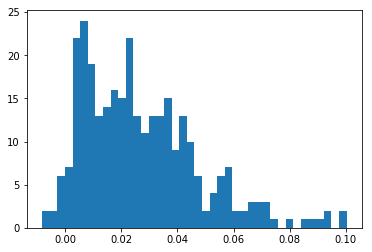

<Figure size 432x288 with 0 Axes>

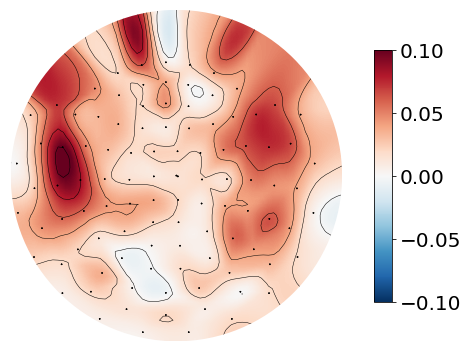

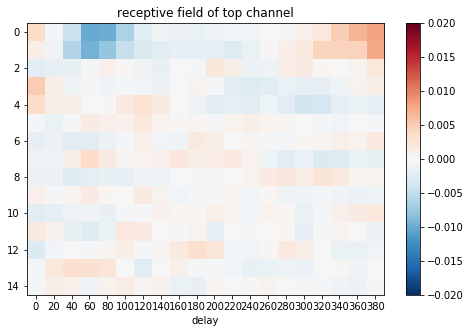

In [25]:
do_run = 1

if do_run:
    # specify X_train, X_test and the delays
    X_train = np.concatenate([zscore(emb_design_mat[s]) for s in train_story_list],axis=0)
    X_test = np.concatenate([zscore(emb_design_mat[s]) for s in test_story_dict.keys()],axis=0)

    delays = np.arange(0,20)
    # specify the timings to understand what it corresponds to:
    print('the time step is {} ms'.format(delta_time))
    print('chosen delays are {} to {} ms'.format(delta_time*delays[0], delta_time*delays[-1]))

    corrs_emb,weights,lambdas = fit_model_predict_test(X_train,Y_train,X_test,Y_test,delays)
    np.save(loc+'corrs_emb.npy',corrs_emb)
    np.save(loc+'weights_emb.npy',weights)
    np.save(loc+'delays_emb.npy',delays)
else:
    corrs_emb = np.load(loc+'corrs_emb.npy',allow_pickle='True')[()]
    weights = np.load(loc+'weights_emb.npy',allow_pickle='True')[()]
    delays = np.load(loc+'delays_emb.npy',allow_pickle='True')[()]

# histogram of the correlations across sensors
plt.figure()
plt.hist(corrs_emb,40);

vmin = -0.1
vmax = 0.1
plt.figure()
single_topoplot(corrs_emb,vmin=vmin,vmax=vmax);
print('Spatial prediction using spectrogram and delays {} to {}'.format(delta_time*delays[0], delta_time*delays[-1]))

plt.figure(figsize=(8,5))
# show weights of top channel?
plt.imshow(np.vstack(np.split(weights[:-1,np.argmax(corrs_spec)],len(delays))).T,
           cmap='RdBu_r',vmin=-0.02,vmax=0.02,aspect='auto');

# spec_bins = spectrum_frequency_bins[story_list[0]]
# plt.yticks(np.arange(len(spec_bins)),spec_bins);
plt.xticks(np.arange(len(delays)),delays*delta_time);
plt.title('receptive field of top channel');
plt.xlabel('delay')
plt.colorbar();

### Semantic analysis, embedding, spatiotemporal


using delays  [-5 -4 -3 -2 -1]
ntrain = 113443
iteration time 5.1935648918151855
using delays  [0 1 2 3 4]
ntrain = 113443
iteration time 4.07801079750061
using delays  [5 6 7 8 9]
ntrain = 113443
iteration time 4.025515794754028
using delays  [10 11 12 13 14]
ntrain = 113443
iteration time 5.412812948226929
using delays  [15 16 17 18 19]
ntrain = 113443
iteration time 6.192259073257446
using delays  [20 21 22 23 24]
ntrain = 113443
iteration time 5.042845010757446
using delays  [25 26 27 28 29]
ntrain = 113443
iteration time 5.094574928283691
using delays  [30 31 32 33 34]
ntrain = 113443
iteration time 4.72298789024353
using delays  [35 36 37 38 39]
ntrain = 113443
iteration time 4.19857382774353


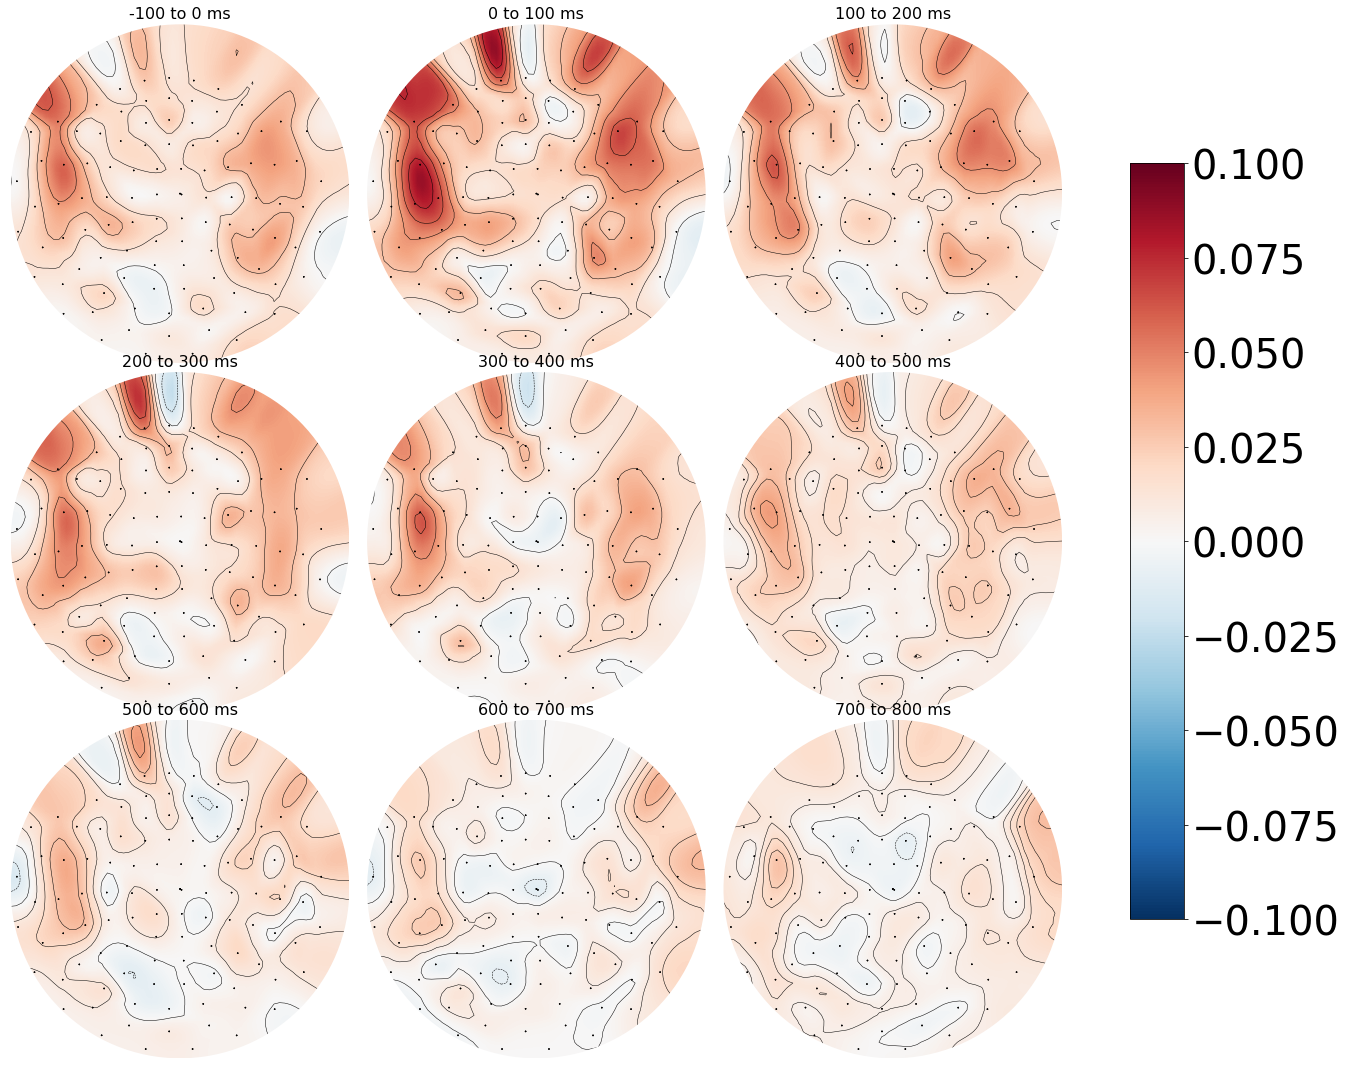

In [26]:
do_run = 1

if do_run:
    
    X_train = np.concatenate([zscore(emb_design_mat[s]) for s in train_story_list],axis=0)
    X_test = np.concatenate([zscore(emb_design_mat[s]) for s in test_story_dict.keys()],axis=0)
   

    # go in steps of 100 ms
    delay_sets = [np.arange(i,i+5) for i in range(-5,40,5)]

    # go in steps of 20 ms
#     delay_sets = [np.arange(i,i+1) for i in range(0,6)]
    corrs_spatiotemporal_emb = np.zeros((306, len(delay_sets)))

    for i,delays in enumerate(delay_sets):
        print('using delays ', delays)
        corrs_spatiotemporal_emb[:,i],__,__ = fit_model_predict_test(X_train,Y_train,
                                                X_test,Y_test,delays)
    np.save(loc+'corrs_spatiotemporal_emb.npy',corrs_spatiotemporal_emb)
    np.save(loc+'delay_sets_emb.npy',delay_sets)
    
else:
    corrs_spatiotemporal_emb = np.load(loc+'corrs_spatiotemporal_emb.npy',allow_pickle='True')[()]
    delay_sets = np.load(loc+'delay_sets_emb.npy',allow_pickle='True')[()]
    

    
vmin = -0.1
vmax = 0.1
time_step = delta_time*len(delay_sets[0])

topoplot(corrs_spatiotemporal_emb,nrow=3,ncol=3,time_step=time_step,
                     time_start=delay_sets[0][0]*delta_time,vmin=vmin,vmax=vmax);



### Semantic analysis, L1, spatial


the time step is 20 ms
chosen delays are 0 to 580 ms
ntrain = 113443
iteration time 10.48128604888916
Spatial prediction using spectrogram and delays 0 to 580


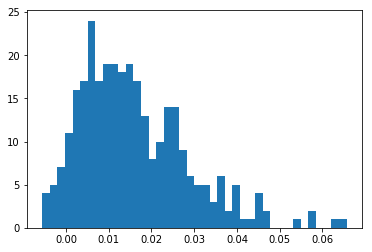

<Figure size 432x288 with 0 Axes>

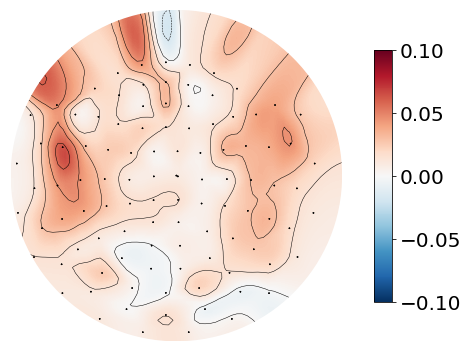

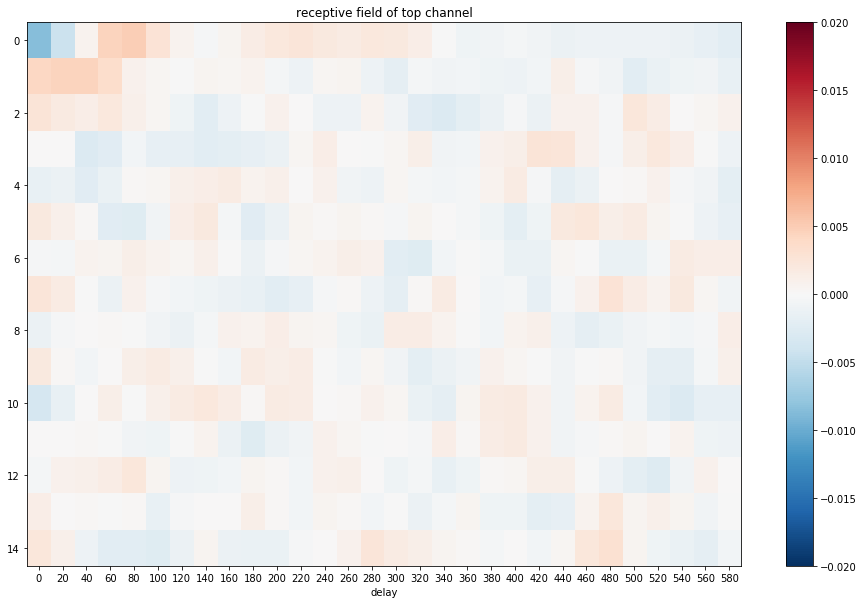

In [27]:
do_run = 1

if do_run:
    # specify X_train, X_test and the delays
    X_train = np.concatenate([zscore(L1_design_mat[s]) for s in train_story_list],axis=0)
    X_test = np.concatenate([zscore(L1_design_mat[s]) for s in test_story_dict.keys()],axis=0)

    delays = np.arange(0,30)
    # specify the timings to understand what it corresponds to:
    print('the time step is {} ms'.format(delta_time))
    print('chosen delays are {} to {} ms'.format(delta_time*delays[0], delta_time*delays[-1]))

    corrs_L1,weights,lambdas = fit_model_predict_test(X_train,Y_train,X_test,Y_test,delays)
    np.save(loc+'corrs_L1.npy',corrs_L1)
    np.save(loc+'weights_L1.npy',weights)
    np.save(loc+'delays_L1.npy',delays)
else:
    corrs_L1 = np.load(loc+'corrs_L1.npy',allow_pickle='True')[()]
    weights = np.load(loc+'weights_L1.npy',allow_pickle='True')[()]
    delays = np.load(loc+'delays_L1.npy',allow_pickle='True')[()]

# histogram of the correlations across sensors
plt.figure()
plt.hist(corrs_L1,40);

vmin = -0.1
vmax = 0.1
plt.figure()
single_topoplot(corrs_L1,vmin=vmin,vmax=vmax);
print('Spatial prediction using spectrogram and delays {} to {}'.format(delta_time*delays[0], delta_time*delays[-1]))

plt.figure(figsize=(16,10))
# show weights of top channel?
plt.imshow(np.vstack(np.split(weights[:-1,np.argmax(corrs_spec)],len(delays))).T,
           cmap='RdBu_r',vmin=-0.02,vmax=0.02,aspect='auto');

# spec_bins = spectrum_frequency_bins[story_list[0]]
# plt.yticks(np.arange(len(spec_bins)),spec_bins);
plt.xticks(np.arange(len(delays)),delays*delta_time);
plt.title('receptive field of top channel');
plt.xlabel('delay')
plt.colorbar();

### Semantic analysis, L1, spatiotemporal


using delays  [-5 -4 -3 -2 -1]
ntrain = 113443
iteration time 5.091980695724487
using delays  [0 1 2 3 4]
ntrain = 113443
iteration time 3.948875904083252
using delays  [5 6 7 8 9]
ntrain = 113443
iteration time 4.638278007507324
using delays  [10 11 12 13 14]
ntrain = 113443
iteration time 4.736164808273315
using delays  [15 16 17 18 19]
ntrain = 113443
iteration time 4.798306941986084
using delays  [20 21 22 23 24]
ntrain = 113443
iteration time 5.149946689605713
using delays  [25 26 27 28 29]
ntrain = 113443
iteration time 4.403677940368652
using delays  [30 31 32 33 34]
ntrain = 113443
iteration time 4.6780290603637695
using delays  [35 36 37 38 39]
ntrain = 113443
iteration time 6.161580801010132


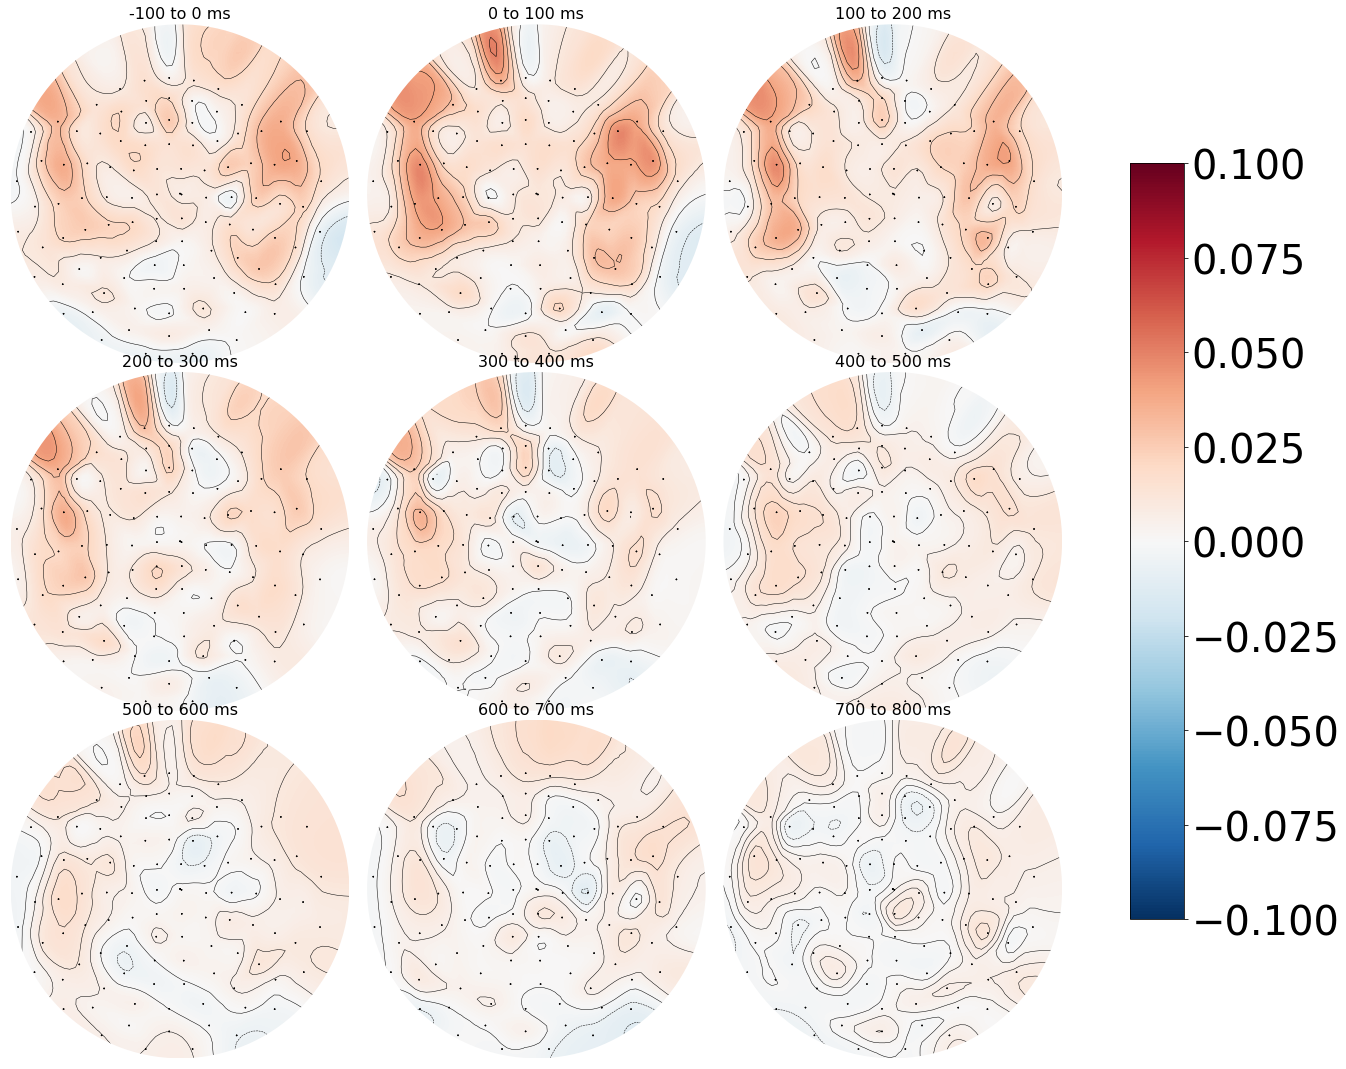

In [28]:
do_run = 1

if do_run:
    
    X_train = np.concatenate([zscore(L1_design_mat[s]) for s in train_story_list],axis=0)
    X_test = np.concatenate([zscore(L1_design_mat[s]) for s in test_story_dict.keys()],axis=0)
   

    # go in steps of 100 ms
    delay_sets = [np.arange(i,i+5) for i in range(-5,40,5)]

    # go in steps of 20 ms
#     delay_sets = [np.arange(i,i+1) for i in range(0,6)]
    corrs_spatiotemporal_L1 = np.zeros((306, len(delay_sets)))

    for i,delays in enumerate(delay_sets):
        print('using delays ', delays)
        corrs_spatiotemporal_L1[:,i],__,__ = fit_model_predict_test(X_train,Y_train,
                                                X_test,Y_test,delays)
    np.save(loc+'corrs_spatiotemporal_L1.npy',corrs_spatiotemporal_L1)
    np.save(loc+'delay_sets_L1.npy',delay_sets)
    
else:
    corrs_spatiotemporal_L1 = np.load(loc+'corrs_spatiotemporal_L1.npy',allow_pickle='True')[()]
    delay_sets = np.load(loc+'delay_sets_L1.npy',allow_pickle='True')[()]
    

    
vmin = -0.1
vmax = 0.1
time_step = delta_time*len(delay_sets[0])

topoplot(corrs_spatiotemporal_L1,nrow=3,ncol=3,time_step=time_step,
                     time_start=delay_sets[0][0]*delta_time,vmin=vmin,vmax=vmax);



### Semantic analysis, supraword, spatial


the time step is 20 ms
chosen delays are 0 to 580 ms
ntrain = 113443
iteration time 19.948183059692383
Spatial prediction using spectrogram and delays 0 to 580


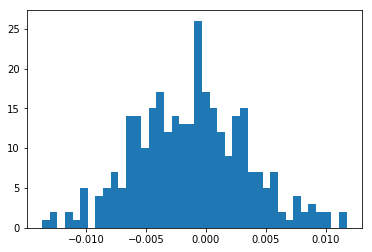

<Figure size 432x288 with 0 Axes>

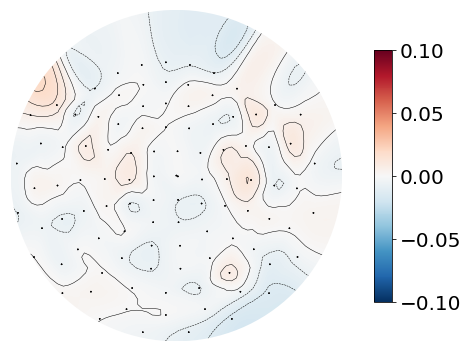

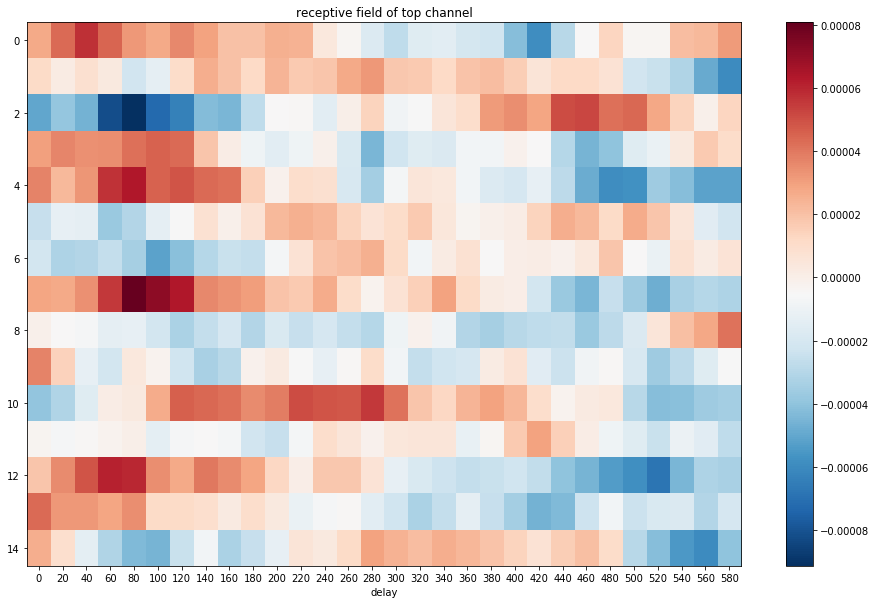

In [29]:
do_run = 1

if do_run:
    # specify X_train, X_test and the delays
    X_train = np.concatenate([zscore(supraword_design_mat[s]) for s in train_story_list],axis=0)
    X_test = np.concatenate([zscore(supraword_design_mat[s]) for s in test_story_dict.keys()],axis=0)

    delays = np.arange(0,30)
    # specify the timings to understand what it corresponds to:
    print('the time step is {} ms'.format(delta_time))
    print('chosen delays are {} to {} ms'.format(delta_time*delays[0], delta_time*delays[-1]))

    corrs_supraword,weights,lambdas = fit_model_predict_test(X_train,Y_train,X_test,Y_test,delays)
    np.save(loc+'corrs_supraword.npy',corrs_supraword)
    np.save(loc+'weights_supraword.npy',weights)
    np.save(loc+'delays_supraword.npy',delays)
else:
    corrs_supraword = np.load(loc+'corrs_supraword.npy',allow_pickle='True')[()]
    weights = np.load(loc+'weights_supraword.npy',allow_pickle='True')[()]
    delays = np.load(loc+'delays_supraword.npy',allow_pickle='True')[()]

# histogram of the correlations across sensors
plt.figure()
plt.hist(corrs_supraword,40);

vmin = -0.1
vmax = 0.1
plt.figure()
single_topoplot(corrs_supraword,vmin=vmin,vmax=vmax);
print('Spatial prediction using spectrogram and delays {} to {}'.format(delta_time*delays[0], delta_time*delays[-1]))

plt.figure(figsize=(16,10))
# show weights of top channel?
plt.imshow(np.vstack(np.split(weights[:-1,np.argmax(corrs_spec)],len(delays))).T,
           cmap='RdBu_r',aspect='auto');

# spec_bins = spectrum_frequency_bins[story_list[0]]
# plt.yticks(np.arange(len(spec_bins)),spec_bins);
plt.xticks(np.arange(len(delays)),delays*delta_time);
plt.title('receptive field of top channel');
plt.xlabel('delay')
plt.colorbar();


### Semantic analysis, supraword, spatiotemporal


using delays  [-5 -4 -3 -2 -1]
ntrain = 113443
iteration time 4.759413957595825
using delays  [0 1 2 3 4]
ntrain = 113443
iteration time 4.233842134475708
using delays  [5 6 7 8 9]
ntrain = 113443
iteration time 4.759287118911743
using delays  [10 11 12 13 14]
ntrain = 113443
iteration time 5.070416212081909
using delays  [15 16 17 18 19]
ntrain = 113443
iteration time 4.780150890350342
using delays  [20 21 22 23 24]
ntrain = 113443
iteration time 5.275044918060303
using delays  [25 26 27 28 29]
ntrain = 113443
iteration time 5.344198226928711
using delays  [30 31 32 33 34]
ntrain = 113443
iteration time 4.84206223487854
using delays  [35 36 37 38 39]
ntrain = 113443
iteration time 5.159430742263794


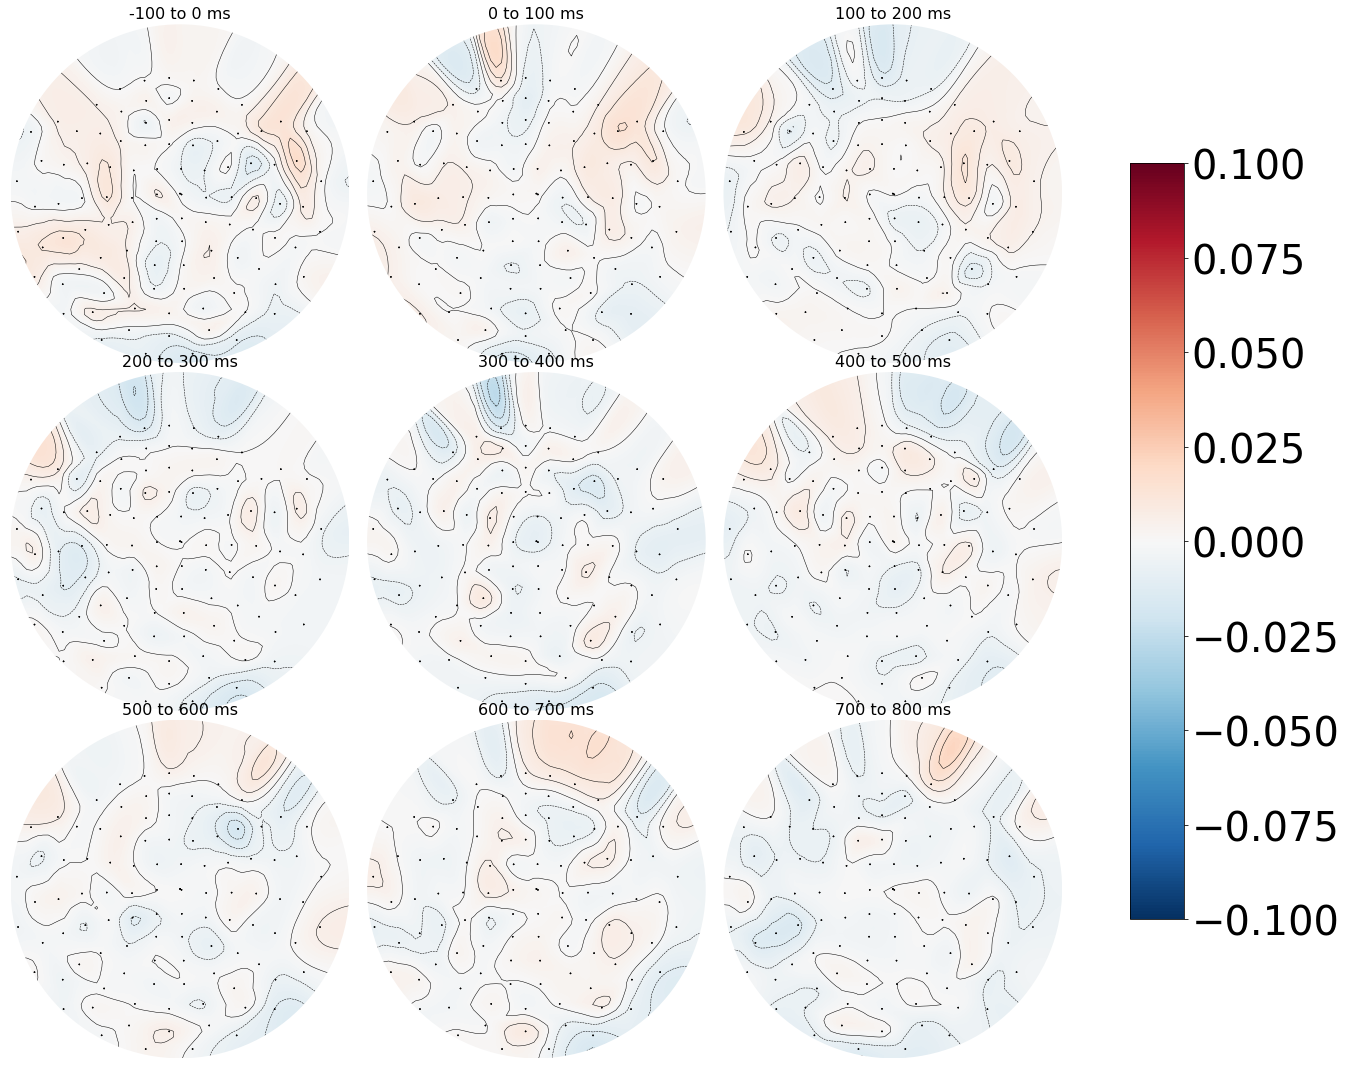

In [30]:
do_run = 1

if do_run:
    
    X_train = np.concatenate([zscore(supraword_design_mat[s]) for s in train_story_list],axis=0)
    X_test = np.concatenate([zscore(supraword_design_mat[s]) for s in test_story_dict.keys()],axis=0)
   

    # go in steps of 100 ms
    delay_sets = [np.arange(i,i+5) for i in range(-5,40,5)]

    # go in steps of 20 ms
#     delay_sets = [np.arange(i,i+1) for i in range(0,6)]
    corrs_spatiotemporal_supraword = np.zeros((306, len(delay_sets)))

    for i,delays in enumerate(delay_sets):
        print('using delays ', delays)
        corrs_spatiotemporal_supraword[:,i],__,__ = fit_model_predict_test(X_train,Y_train,
                                                X_test,Y_test,delays)
    np.save(loc+'corrs_spatiotemporal_supraword.npy',corrs_spatiotemporal_supraword)
    np.save(loc+'delay_sets_supraword.npy',delay_sets)
    
else:
    corrs_spatiotemporal_supraword = np.load(loc+'corrs_spatiotemporal_supraword.npy',allow_pickle='True')[()]
    delay_sets = np.load(loc+'delay_sets_supraword.npy',allow_pickle='True')[()]
    

    
vmin = -0.1
vmax = 0.1
time_step = delta_time*len(delay_sets[0])

topoplot(corrs_spatiotemporal_supraword,nrow=3,ncol=3,time_step=time_step,
                     time_start=delay_sets[0][0]*delta_time,vmin=vmin,vmax=vmax);

